<a href="https://colab.research.google.com/github/cmentus/deep_vision_models/blob/main/Segmentation_ResNet_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model
Image segmentation model with U-Net architecture, leveraging feature layers from trained ResNet model. 

# Losses
We define a module for making custom losses out of loss function primatives. 

## Loss function primitives
Two types of distance function. Optional spatial blur in the loss to include spatial information. It may help with finding the global optimum more quickly. Wasserstein distance includes distance by definition. 

*   **Dice**
*   **Binary Cross Entropy**

*   **Jensen-Shannon Divergence**
*   **Wasserstein/ Sinkhorn approximation (work in progress)** - This can be approximated using an iterative matrix formulation. Therefore we can backprop gradients through this loss layer!

The last two are distances between probability on the rectangle. The first are distances between conditional probability pixel = 1 give x,y coordinate.



In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models
import torch.nn.functional as F
!git clone https://github.com/cmentus/deep_vision_models.git
!pip install gdown

fatal: destination path 'deep_vision_models' already exists and is not an empty directory.


In [ ]:
sys.path.append( 'deep_vision_models/lib')
import dataset, resnet_unet, losses_segmentation, segmentation_training_loop
from dataset import *
from losses_segmentation import *
from resnet_unet import *
from segmentation_training_loop import *

In [ ]:
import gdown
gdown.download(id='1-HtpZsCwy0Tp9kAFKsXKiIDrZqCjdhDA', 
               output='val_dic.pt', quiet=False)
gdown.download(id='1-3NRLdIDGzIBbsMoXQkFwDQ3-Gxg7KQU', 
               output='test_dic.pt', quiet=False)
gdown.download(id='14in2YJzCuFM-7NYqhk7-0qzUqnkBVIin', 
               output='train_dic.pt', quiet=False)



Downloading...
From: https://drive.google.com/uc?id=1-HtpZsCwy0Tp9kAFKsXKiIDrZqCjdhDA
To: /content/val_dic.pt
100%|██████████| 189M/189M [00:01<00:00, 118MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-3NRLdIDGzIBbsMoXQkFwDQ3-Gxg7KQU
To: /content/test_dic.pt
100%|██████████| 1.87G/1.87G [00:11<00:00, 169MB/s]
Downloading...
From: https://drive.google.com/uc?id=14in2YJzCuFM-7NYqhk7-0qzUqnkBVIin
To: /content/train_dic.pt
100%|██████████| 1.68G/1.68G [00:09<00:00, 182MB/s]


'train_dic.pt'

In [ ]:
#@markdown #**Select data directory**
#@markdown ---
use_gdrive = False #@param {type:"boolean"}
project_dir = 'drive/MyDrive/MedicalUNet' #@param {type:"string"}
data_dir = '/'#@param {type:"string"}
if use_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')

# Load Data

In [ ]:
train_dict = torch.load('train_dic.pt')
val_dict = torch.load('val_dic.pt')
test_dict = torch.load('test_dic.pt')

## Make dataset objects

In [ ]:
train_dataset = ImageLabelDataset(train_dict['images'].type(torch.float32), train_dict['codes'].type(torch.float32),train_dict['labels'].type(torch.float32))
#test_dataset = ImageLabelDataset(test_dict['images'], test_dict['codes'],test_dict['labels'])
val_dataset = ImageLabelDataset(val_dict['images'].type(torch.float32), val_dict['codes'].type(torch.float32),val_dict['labels'].type(torch.float32))

#dataloaders_all = {
 # 'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
  #'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
#}



In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)

In [ ]:
del(train_dict)
#del(test_dict)
del(val_dict)

torch.Size([5, 256, 256])

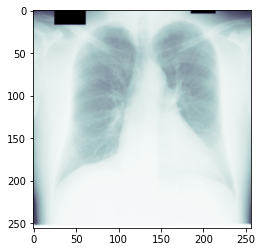

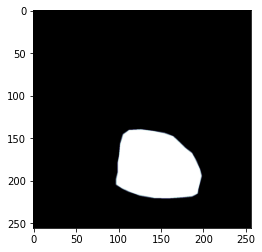

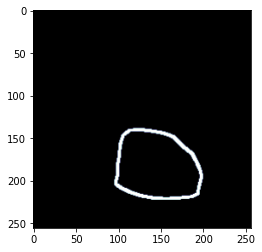

In [ ]:
img, code, mask, contour = train_dataset.__getitem__(0)
plt.figure()
plt.imshow(img[0], 'bone')
plt.figure()
plt.imshow(torch.sum(mask,0),'bone')
plt.figure()
plt.imshow(torch.sum(contour,0),'bone')
contour.shape
#img.shape
#mask.shape

# U-Net Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda


In [ ]:
# Try encoder and decoder
from torchsummary import summary
encoder = Encoder()
encoder = encoder.to(device)
summary(encoder,input_size = (3,256,256))


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5         [-1, 64, 128, 128]           9,408
            Conv2d-6         [-1, 64, 128, 128]           9,408
       BatchNorm2d-7         [-1, 64, 128, 128]             128
       BatchNorm2d-8         [-1, 64, 128, 128]             128
              ReLU-9         [-1, 64, 128, 128]               0
             ReLU-10         [-1, 64, 128, 128]               0
        MaxPool2d-11           [-1, 64, 64, 64]               0
        MaxPool2d-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]          36,864
           Conv2d-14           [-1, 64,

In [ ]:
model = EncDecResNetUNet(10)
model = model.to(device)
summary(model,input_size = (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5         [-1, 64, 128, 128]           9,408
            Conv2d-6         [-1, 64, 128, 128]           9,408
       BatchNorm2d-7         [-1, 64, 128, 128]             128
       BatchNorm2d-8         [-1, 64, 128, 128]             128
              ReLU-9         [-1, 64, 128, 128]               0
             ReLU-10         [-1, 64, 128, 128]               0
        MaxPool2d-11           [-1, 64, 64, 64]               0
        MaxPool2d-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]          36,864
           Conv2d-14           [-1, 64,

# Define Visualization

In [ ]:
img, code, mask, contour = next(iter(train_dataloader))

img = img.to(device) 
code = code.to(device) 
mask = mask.to(device) 
contour = contour.to(device)

prediction=model(img)

vis_img = img.cpu()[0]
vis_prediction = prediction.cpu()[0]
vis_mask = mask.cpu()[0]
vis_contour = contour.cpu()[0]
contour.dtype

torch.float32

In [ ]:
def visualize(vis_img,vis_prediction,vis_mask,vis_contour,epoch,dir):
    f,ax = plt.subplots(2,2,figsize=(10,10))
    ax[0,0].imshow(vis_img[0],cmap='bone',vmin=.3)
    ax[0,0].set_title('image epoch:'+str(epoch),fontsize=20)

    ax[1,0].imshow(np.sum(vis_prediction[:5].detach().numpy(),0),cmap='Greys')
    ax[1,0].set_title('all predicted masks epoch:'+str(epoch),fontsize=20)

    ax[1,1].imshow(np.sum(vis_prediction[-5:].detach().numpy(),0),cmap='Greys')
    ax[1,1].set_title('all predicted contours epoch:'+str(epoch),fontsize=20)

    ax[0,1].imshow(torch.sum(vis_mask,0),cmap='Greys')
    ax[0,1].set_title('truth epoch:'+str(epoch),fontsize=20)
    f.tight_layout()
    f.savefig(dir+str(epoch)+'img_mask_pred.png')

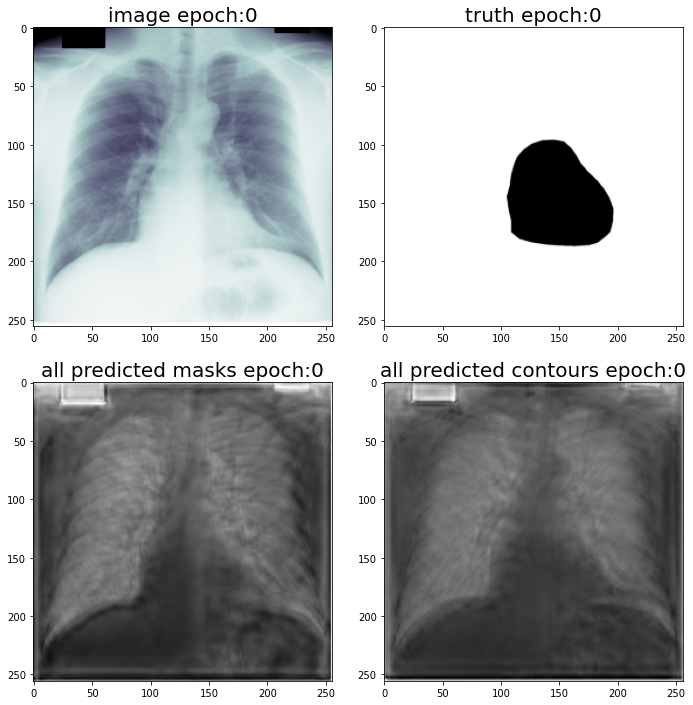

In [ ]:
visualize(vis_img,vis_prediction,vis_mask,vis_contour,epoch=0,dir='')

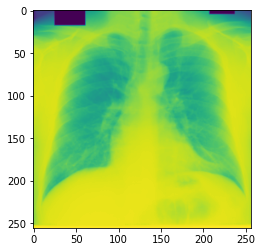

In [ ]:
plt.imshow(vis_img[0].flatten(start_dim=0).view((256,256)))

# Loss function primitives
Two types of distance function. Optional spatial blur in the loss to include spatial information. It may help with finding the global optimum more quickly.

*   Dice
*   Binary Cross Entropy

*   Jensen-Shannon Divergence
*   Wasserstein/ Sinkhorn approximation (work in progress)

The last two are distances between probability on the rectangle. The first are distances between conditional probability pixel = 1 give x,y coordinate.


# Unit Test

In [ ]:
test_dataloader = DataLoader(val_dataset, batch_size=30, shuffle=True, num_workers=0)

def test_model(model, test_dataloader, metric_dict):
       model.eval()
  
       test_metrics = {k: [] for k in metric_dict.keys()}
       for img, code, mask, contour in test_dataloader:

              prediction=model(img)
              target=mask
              with torch.no_grad():
                    for k, metric_loss in metrics.items():
                        epoch_metrics[k] += metric_loss(target,prediction,code)/len(dataloader) #divide by number batches

In [ ]:
# Test the primitives
img, code, mask, contour = next(iter(train_dataloader))
loss_list = [JSBlurLoss(5,list(range(5))),JSBlurLoss(3,list(range(5,10))),
                             BCEBlurLoss(1,list(range(5))),BCEBlurLoss(1,list(range(5,10)))]
loss_weights = [1.,1.,1.,1. ]
lossfn = TotalLoss(losses = loss_list,
          weights = loss_weights).to(device)
bce_loss = BCEBlurLoss(1,list(range(5)))
bce_loss = bce_loss.to(device)
#prediction = prediction.to(device)
code = code.to(device)
mask = mask.to(device) 
contour = contour.to(device)
print(bce_loss(torch.concat([mask,contour],dim=1),prediction,code))

js_loss = JSBlurLoss(1,list(range(5)))
js_loss = js_loss.to(device)
js_loss(torch.concat([mask,contour],dim=1),prediction,code)
lossfn(torch.concat([mask,contour],dim=1),prediction,code)

tensor(0.2813, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


tensor(0.6550, device='cuda:0', grad_fn=<AddBackward0>)

Testing to device

In [ ]:
model = EncDecResNetUNet(10).to(device)
img, code, mask, contour = next(iter(train_dataloader))



In [ ]:
lossfn.get_submodule('3')

BCEBlurLoss(
  (blurrer): Conv2d(5, 5, kernel_size=(1, 1), stride=(1, 1), bias=False)
)

# Define metric dict

In [ ]:
metric_dict = {'bce_mask':BCEBlurLoss(1,list(range(5))).to(device), 
            'bce_contour':BCEBlurLoss(1,list(range(5,10))).to(device),
            'JS_mask':JSBlurLoss(1,list(range(5))).to(device),
            'JS_contour':JSBlurLoss(1,list(range(5,10))).to(device),
             'blurrydice_mask': BlurryDiceLoss(1,list(range(5))).to(device),
             'blurrydice_contour': BlurryDiceLoss(1,list(range(5,10))).to(device)
}

In [ ]:
#@title Set savedrive and hyperstring
#@markdown ---

savedrive = '/' #@param {type : "string"}
hyperstring = '/test2/' #@param {type : "string"}

try:
    os.makedirs(savedrive+hyperstring, exist_ok=False) 
except:
    None

# Train the model

Create data loader

In [ ]:
dataloaders = {'train': DataLoader(train_dataset, batch_size=30, shuffle=True, num_workers=0),
'val': DataLoader(val_dataset, batch_size=30, shuffle=True, num_workers=0)}

# Loss combo with weights
Chooses different losses with different scales of blur

In [ ]:
loss_list = [BCEBlurLoss(3,list(range(5))),
             BCEBlurLoss(3,list(range(5,10))),
            JSBlurLoss(7,list(range(5))),
             JSBlurLoss(7,list(range(5,10))),
            JSBlurLoss(1,list(range(5))),
             JSBlurLoss(1,list(range(5,10)))]
loss_weights = [1.,1.,1.,1.,1.,1.]


In [ ]:
lossfn = TotalLoss(losses = loss_list,
          weights = loss_weights).to(device)
#lossfn= BCEBlurLoss(1,list(range(5))).to(device)
metric_dict = {'bce_mask':BCEBlurLoss(1,list(range(5))).to(device), 
            'bce_contour':BCEBlurLoss(1,list(range(5,10))).to(device),
            'JS_mask':JSBlurLoss(1,list(range(5))).to(device),
            'JS_contour':JSBlurLoss(1,list(range(5,10))).to(device)}


train: bce_mask: 0.119424, bce_contour: 0.070300, JS_mask: 0.027992, JS_contour: 0.041006
val: bce_mask: 0.092910, bce_contour: 0.033334, JS_mask: 0.026387, JS_contour: 0.038974


TypeError: ignored

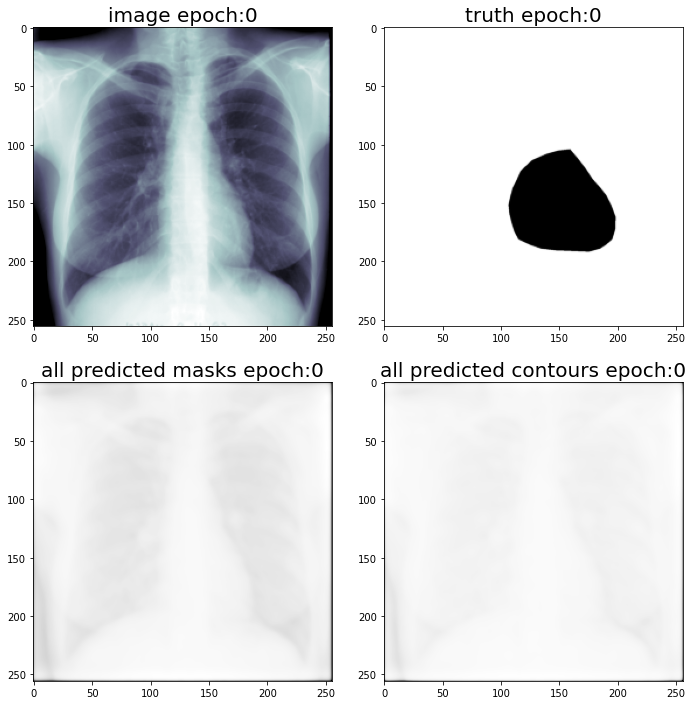

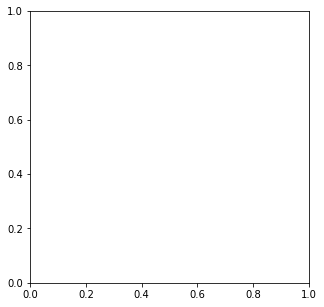

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler


LR = 1E-3
GAMMA = .9

model = EncDecResNetUNet(10).to(device)
optimizer_ft_all = optim.Adam(filter(lambda p: p.requires_grad, # require grad params will be trained. so no resnet.
                                     model.parameters()), lr=LR)

exp_lr_scheduler_all = lr_scheduler.StepLR(optimizer_ft_all, step_size=35, gamma=GAMMA)
train_model(dataloaders, 
                model,301,
                lossfn, # function form loss(target,prediction,code)
                metric_dict, # dictionary string : f(target,prediction,code) #print metrics, record in dict -> list, plot.
                optimizer = optimizer_ft_all, 
                scheduler=exp_lr_scheduler_all, 
                    visualize= visualize, # plot the mask, ground truth etc. visualize(input,prediction,target,epoch,dir) (done)
                plot_epoch = 1,
                savedir=savedrive + hyperstring)

In [ ]:
model